In [50]:
#packages to import to run the code in the Jupyter Notebook
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io
import cv2
import os
import mediapipe as mp
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout
from keras.utils import to_categorical
import time
from memory_profiler import memory_usage
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

Information about the data set 
                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0 

Labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10873 entries, 0 to 10872
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   10873 non-null  object
 1   label   10873 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 170.0+ KB

 Labels after dropping J and Z:  [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 

 Changed labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] 

<class

C:\Users\dulan\AppData\Local\Temp\ipykernel_23536\755347104.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].map(label_mapping)


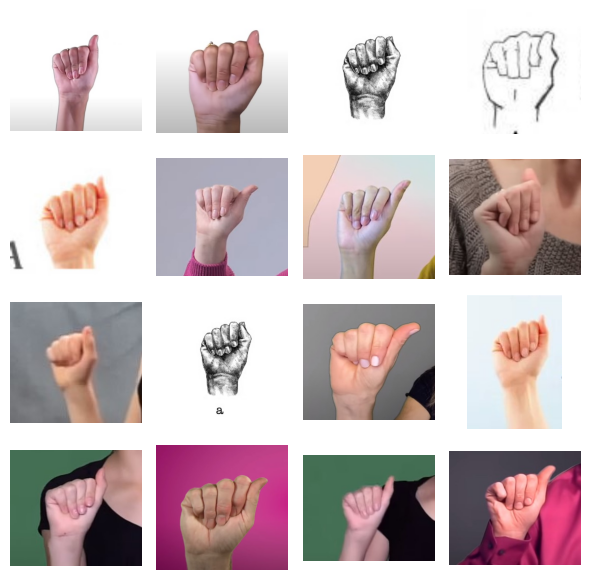

In [5]:
#Getting the dataset
df = pd.read_parquet("hf://datasets/Marxulia/asl_sign_languages_alphabets_v03/data/train-00000-of-00001.parquet")

print("Information about the data set ")

print(df.head(), "\n") # Inspect the first few rows of the DataFrame

print("Labels: ", df['label'].unique(), "\n") #Image labels stands for A=0, B=1.., Z=25

df.info()

# J = 9, Z = 25 are motion-based so will not be used in the model
labels_to_drop = [9, 25]
data = df[~df['label'].isin(labels_to_drop)] # Drop rows
print("\n Labels after dropping J and Z: ", data['label'].unique(), "\n") # Verify the results

label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(data['label'].unique()))} #Changing the labels
data['label'] = data['label'].map(label_mapping) 
print(" Changed labels: ", data['label'].unique(), "\n") # Verify the results

data.info()

print("\nCount of null data:\n",  data.isnull().sum(), "\n")
print("Images per label:\n", data["label"].value_counts(), "\n")

#Look at the images present in dataset
num_images = 16
gride_size = 4
num_images = min(len(data), 16)  # Display up to 16 images
grid_size = int(num_images**0.5) + (1 if num_images**0.5 % 1 > 0 else 0)

plt.figure(figsize=(6, 6))

print("Images from Dataset")
for i in range(num_images):
    image_data = data.iloc[i]['image']['bytes']
    img = Image.open(io.BytesIO(image_data))
    
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off') 

plt.tight_layout()
plt.show()

In [17]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

images = []
labels = []

for _, row in data.iterrows():
    data_aux = []
    x_ = []
    y_ = []
    
    # Extract the image bytes
    image_data = row['image']['bytes']
    
    # Decode the binary data to image
    img = Image.open(io.BytesIO(image_data)).convert('RGB')

    img_np = np.array(img)  # Convert RGB image to NumPy array

    # Process the image using Mediapipe to get x, y coordinates
    results = hands.process(img_np)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y

                x_.append(x)
                y_.append(y)

            # Normalize landmarks
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                data_aux.append(x - min(x_))
                data_aux.append(y - min(y_))

        # Append data only if they have 42 landmarks
        if len(data_aux) == 42:
            images.append(data_aux)
            labels.append(row['label'])  # Use label from DataFrame

images = np.asarray(images)
labels = np.asarray(labels)
labels = to_categorical(labels, num_classes=24)

# Split data into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, stratify=y_train)

print("x_train: " ,x_train.shape)
print("x_test: " ,x_test.shape)
print("x_val: " ,x_val.shape)
print("y_train: " ,y_train.shape)
print("y_test: " ,y_test.shape)
print("y_val: " ,y_val.shape)


x_train:  (4779, 42)
x_test:  (1594, 42)
x_val:  (1594, 42)
y_train:  (4779, 24)
y_test:  (1594, 24)
y_val:  (1594, 24)


In [85]:
# Converting images to a suitable shape for CNN: each data point has 42 features
x_train = np.array(x_train).reshape(-1, 42, 1)
x_val = np.array(x_val).reshape(-1, 42, 1)
x_test = np.array(x_test).reshape(-1, 42, 1)

# The CNN model with 2 1D layers
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(42, 1)),
    Dropout(0.5),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\dulan\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)                   │ (None, 40, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 38, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 4864)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         622,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 24)                  │           3,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 650,776 (2.48 MB)

 Trainable params: 650,776 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
start_time = time.time()
mem_usage = memory_usage((model.fit, (x_train, y_train)))  # Measure memory during training

# Train the model
training = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

finish_time = time.time()

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9386 - loss: 0.1707
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9280 - loss: 0.1808 - val_accuracy: 0.9197 - val_loss: 0.3527
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9418 - loss: 0.1685 - val_accuracy: 0.9153 - val_loss: 0.3720
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9396 - loss: 0.1649 - val_accuracy: 0.9109 - val_loss: 0.3852
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9463 - loss: 0.1649 - val_accuracy: 0.9197 - val_loss: 0.3966
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9440 - loss: 0.1500 - val_accuracy: 0.9178 - val_loss: 0.3659
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9426 - loss: 0.1625 - val_accuracy: 0.9241 - val_loss: 0.3745
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9438 - loss: 0.1577 - val_accuracy: 0.9172 - val_loss: 0.3633
Epoch 8/10
150/150 ━━

Model Evaluation 



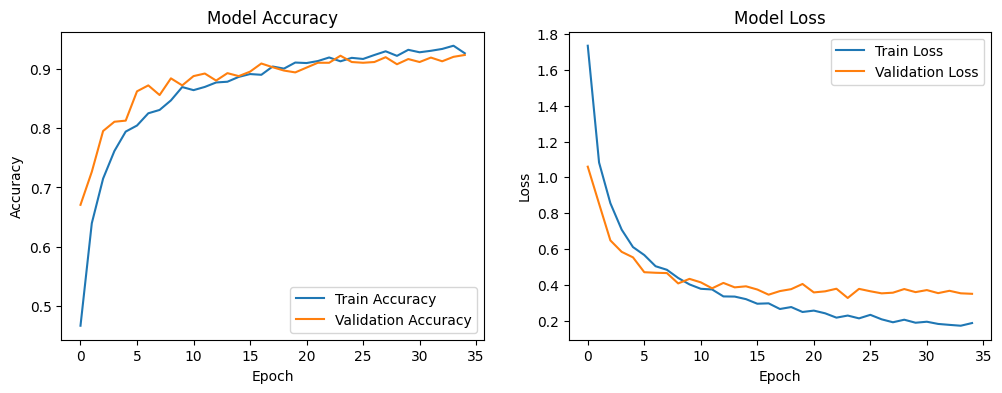

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9295 - loss: 0.3302
Validation Loss: 0.35064688324928284
Validation Accuracy: 0.9240903258323669 

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Predicted labels: [ 7 19 14 ...  0  6 14]
True labels: [ 7 20 14 ...  0  6 14]


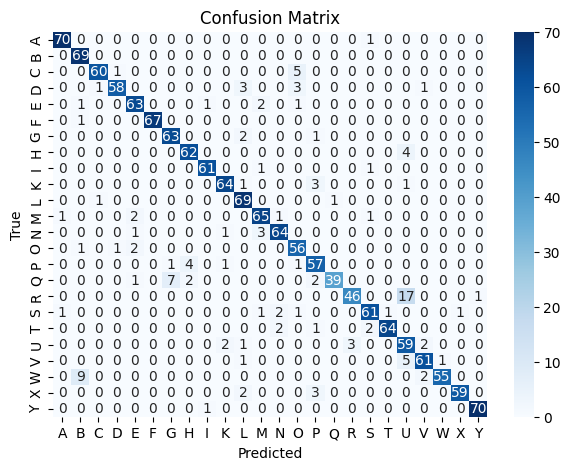

Classification Report:
               precision    recall  f1-score   support

           A       0.99      1.00      0.99        71
           B       0.97      1.00      0.99        69
           C       0.97      0.92      0.95        66
           D       0.97      0.97      0.97        66
           E       0.95      0.91      0.93        68
           F       1.00      0.99      0.99        68
           G       0.94      0.92      0.93        66
           H       0.90      1.00      0.95        66
           I       0.93      0.98      0.95        63
           K       0.97      0.91      0.94        69
           L       0.93      0.97      0.95        71
           M       0.90      1.00      0.95        70
           N       0.94      0.88      0.91        69
           O       0.91      0.97      0.94        60
           P       0.86      0.88      0.87        64
           Q       0.89      0.82      0.86        51
           R       0.89      0.86      0.87        64
   

In [83]:
print("Model Evaluation \n")

# Accuracy vs Epoch plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training.history['accuracy'], label='Train Accuracy')
plt.plot(training.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss vs Epoch plot
plt.subplot(1, 2, 2)
plt.plot(training.history['loss'], label='Train Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluating the model

labels_dict = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R',
    17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'
}

val_loss, val_accuracy = model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy, "\n")

#Predict the test data
preds = model.predict(x_test)
print("Predicted labels:", tf.argmax(preds, axis=1).numpy())
print("True labels:", tf.argmax(y_test, axis=1).numpy())

#Confusion matrix
c_matrix = confusion_matrix(tf.argmax(y_test, axis=1).numpy(), tf.argmax(preds, axis=1).numpy())                 
plt.figure(figsize=(7, 5))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_dict.values(), yticklabels=labels_dict.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
report = classification_report(y_test_labels, y_pred, target_names=labels_dict.values())
print("Classification Report:\n", report)

# Evaluation metrics
time_taken =  finish_time - start_time
loss, acc = model.evaluate(x_test, y_test, verbose=0)

y_test_labels = tf.argmax(y_test, axis=1).numpy()
y_pred = tf.argmax(preds, axis=1).numpy()

precision = precision_score(y_test_labels, y_pred, average='weighted')  # Use 'macro' for unweighted average
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')  # Use 'macro' for unweighted average

print(f"Training Memory Usage: {max(mem_usage):.6}MB\n")
print(f"Training Time: {time_taken:.4}s\n")
print(f"Accuracy: {(acc*100):.4}%\n")
print(f"Precision: {precision:.4}\n")
print(f"Recall: {recall:.4}\n")
print(f"F1 Score: {f1:.4}\n")

In [ ]:
import cv2
import numpy as np
import mediapipe as mp

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

# Start video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Frame dimensions
    H, W, _ = frame.shape

    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with Mediapipe
    results = hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw landmarks
            mp_drawing.draw_landmarks(
                frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

            # Extract landmarks
            x_ = [lm.x for lm in hand_landmarks.landmark]
            y_ = [lm.y for lm in hand_landmarks.landmark]

            # Normalize landmarks to the frame size
            x_ = [(x * W) for x in x_]
            y_ = [(y * H) for y in y_]

            # Create a feature vector from landmarks
            data_aux = []
            for i in range(len(hand_landmarks.landmark)):
                data_aux.append(x_[i] - min(x_))  # Normalize x
                data_aux.append(y_[i] - min(y_))  # Normalize y

            # Ensure we have 42 features (21 landmarks * 2)
            if len(data_aux) == 42:
                roi = np.array(data_aux).reshape(1, 42, 1)  # Reshape for CNN model

                # Predict the sign
                prediction = model.predict(roi)
                predicted_character = labels_dict[np.argmax(prediction)]

                # Display the predicted character
                cv2.rectangle(frame, (int(min(x_)), int(min(y_))), (int(max(x_)), int(max(y_))), (0, 255, 0), 2)
                cv2.putText(frame, predicted_character, (int(min(x_)), int(min(y_)) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Hand Sign Recognition', frame)

    # Break loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━